# Passo 1. Setup do projeto

In [53]:
import os
import urllib
import re

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [54]:
CRX_ROOT = 'http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/'
CRX_URL = CRX_ROOT+'crx.data'

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'crx.csv'

CRX_DATA = os.path.join(DATA_PATH, DATA_FILE)

# Passo 2. Recuperação dos dados

In [55]:
def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)

download_data(CRX_URL, DATA_PATH, DATA_FILE)

In [56]:
#Names retirado de http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html
names = '''Male          
Age           
Debt          
Married       
BankCustomer  
EducationLevel
Ethnicity     
YearsEmployed 
PriorDefault  
Employed      
CreditScore   
DriversLicense
Citizen       
ZipCode       
Income        
Approved'''

names = re.split('[\n]', names.replace(" ", ""))

crx_data = pd.read_csv(CRX_DATA, header=None, names=names)
crx_data

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-


# Passo 3. Análise exploratória dos dados

In [57]:
crx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Male            690 non-null    object 
 1   Age             690 non-null    object 
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    object 
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


## Verificação dos dados ausentes

In [58]:
#De acordo com o documento em http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html os dados ausentes estão marcados com o caracter "? "
crx_data[crx_data[names] == '?'].count()

Male              12
Age               12
Debt               0
Married            6
BankCustomer       6
EducationLevel     9
Ethnicity          9
YearsEmployed      0
PriorDefault       0
Employed           0
CreditScore        0
DriversLicense     0
Citizen            0
ZipCode           13
Income             0
Approved           0
dtype: int64

In [59]:
#De acordo com o documento em http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html as colunas que tem correlação com a concessão ou não de crédito são as colunas Prior default, Years employed, Credit score e Income level. Foi adicionado também a coluna Debt. Os outros dados foram dispensados por não possuir correlação com a variável alvo da coluna Approved.
crx_data = crx_data[['Debt','YearsEmployed', 'PriorDefault', 'CreditScore', 'Income', 'Approved']]
crx_data

,Debt,YearsEmployed,PriorDefault,CreditScore,Income,Approved
0,0.000,1.25,t,1,0,+
1,4.460,3.04,t,6,560,+
2,0.500,1.50,t,0,824,+
3,1.540,3.75,t,5,3,+
4,5.625,1.71,t,0,0,+
...,...,...,...,...,...,...
685,10.085,1.25,f,0,0,-
686,0.750,2.00,f,2,394,-
687,13.500,2.00,f,1,1,-
688,0.205,0.04,f,0,750,-


In [60]:
#As colunas PriorDefault e Approved precisam ser convertidas para dados númericos substituindo t por 1 e f por 0 na coluna PriorDefault e + por 1 e - por 0 na coluna Approved
enc = LabelEncoder()
crx_data['PriorDefault'] = enc.fit_transform(crx_data['PriorDefault'])
crx_data['Approved'] = enc.fit_transform(crx_data['Approved'])
crx_data

,Debt,YearsEmployed,PriorDefault,CreditScore,Income,Approved
0,0.000,1.25,1,1,0,0
1,4.460,3.04,1,6,560,0
2,0.500,1.50,1,0,824,0
3,1.540,3.75,1,5,3,0
4,5.625,1.71,1,0,0,0
...,...,...,...,...,...,...
685,10.085,1.25,0,0,0,1
686,0.750,2.00,0,2,394,1
687,13.500,2.00,0,1,1,1
688,0.205,0.04,0,0,750,1


In [61]:
#Apesar das colunas Debt, YearEmployed, CreditScore, Income possuirem dados nulos, esses dados não foram retirados porque podem ser zero. 
crx_data.describe()[['Debt', 'YearsEmployed', 'CreditScore', 'Income']]

,Debt,YearsEmployed,CreditScore,Income
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


# Passo 4. Avaliação dos classficadores

In [62]:
X = crx_data.drop(['Approved'], axis=1)
y = crx_data['Approved']
 

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

In [64]:
#Normalização dos dados. Melhorou o desempenho do SVM e aumentou a acurácia em todos os classificadores.
scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [65]:
def build_classifiers():
    classifiers = []
    classifiers.append(
                      ('knn',                              # nome do classificador
                        KNeighborsClassifier(),            # instancia do classificador
                        {'n_neighbors' : range(1, 33, 2)}  # hiperparametros
                      )
    )
    
    classifiers.append(
                      ('lr',                               
                        LogisticRegression(max_iter=1000), 
                        {'penalty' : ['l2'], 'C' : [100, 10, 1, 0.1, 0.01]}  
                      )
    )
    
    classifiers.append(
                      ('svm',
                        SVC(max_iter=1000),
                        {'kernel' : ['linear', 'rbf'], 
                         'C' : [2 ** (-5), 1, 2 ** 5, 2 ** 10],
                         'gamma' : [2 ** (-15), 2 ** (-10), 2 ** (-5), 1, 2 ** 5],
                         'cache_size': [1000],
                        }
                      )
    )
    
    classifiers.append(
                      ('dt',
                        DecisionTreeClassifier(),
                        {'max_depth' : [2, 4, 6, 8, 10, 12]}
                      )  
    )
    
    classifiers.append(
                      ('rf',
                        RandomForestClassifier(),
                        {'n_estimators' : [10, 50, 100]}
                      ) 
    )

    classifiers.append(
                    ('gnb', 
                      GaussianNB(),
                      {'var_smoothing': [1E-8, 1E-9, 1E-10]}
                    )
    ) 
    
    return classifiers

In [66]:
classifiers = build_classifiers()
results = []
names = []

for name, model , parameters in classifiers:
    print('\n>> classifier name: {}'.format(name))
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, n_jobs=3)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv = cross_val_score(gs, X, y, cv=kf, scoring='accuracy')
    print('Mean: {}, Standart Deviation: {}'.format(cv.mean(), cv.std()))
    gs.fit(X_train, y_train)
    print("Best parameters: {}".format(gs.best_params_))
    print("Best score: {}".format(gs.best_score_))
    results.append(cv)
    names.append(name)



>> classifier name: knn
Mean: 0.7289855072463769, Standart Deviation: 0.049699791882557263
Best parameters: {'n_neighbors': 9}
Best score: 0.8716924398625429

>> classifier name: lr
Mean: 0.8550724637681159, Standart Deviation: 0.022915055508466543
Best parameters: {'C': 100, 'penalty': 'l2'}
Best score: 0.871692439862543

>> classifier name: svm
Mean: 0.7463768115942029, Standart Deviation: 0.06609712609270363
Best parameters: {'C': 1, 'cache_size': 1000, 'gamma': 1, 'kernel': 'rbf'}
Best score: 0.871692439862543

>> classifier name: dt
Mean: 0.855072463768116, Standart Deviation: 0.018896238855659858
Best parameters: {'max_depth': 2}
Best score: 0.8634450171821306

>> classifier name: rf
Mean: 0.8420289855072465, Standart Deviation: 0.026086956521739143
Best parameters: {'n_estimators': 10}
Best score: 0.8612542955326461

>> classifier name: gnb
Mean: 0.7608695652173914, Standart Deviation: 0.04323604026138059
Best parameters: {'var_smoothing': 1e-08}
Best score: 0.7722508591065291


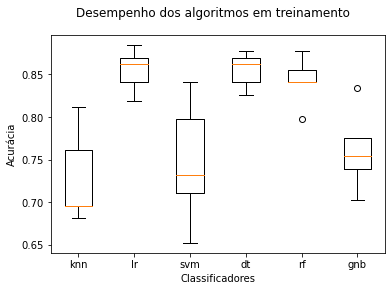

In [67]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos em treinamento')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_xlabel('Classificadores')
ax.set_ylabel('Acurácia')
plt.show()

Entre os classificadores, o que teve o melhor desempenho foi o Logistic Regression com os hiperparâmetros 'C': 100, 'penalty': 'l2'

In [68]:
clf = LogisticRegression(max_iter=1000, C=100, penalty='l2')
clf.fit(X_train, y_train)
y_model = clf.predict(X_test)
score = accuracy_score(y_model, y_test)
report = classification_report(y_model, y_test)

print("Score: {}".format(score))
print(report)

Score: 0.821256038647343
              precision    recall  f1-score   support

           0       0.89      0.75      0.82       109
           1       0.77      0.90      0.83        98

    accuracy                           0.82       207
   macro avg       0.83      0.83      0.82       207
weighted avg       0.83      0.82      0.82       207



# Conclusão

O modelo de melhor desempenho foi o Logistic Regression, o qual apresentou um score de 82% com os dados de testes e um bom f1-score.